# 프로젝트 : 폐렴 진단기 성능개선
***
## < 목차 >
#### Step 1. 실험환경 Set-up
#### Step 2. 데이터 준비하기
- Data Augmentation

#### Step 3. 데이터 시각화
#### Step 4. CNN 모델링
#### Step 5. 데이터 imbalance 처리
#### Step 6. 모델 훈련
#### Step 7. 결과 확인
#### 🤔회고🤔
#### Reference

***

# Step 1. 실험환경 Set-up
-  패키지(라이브러리)들을 import 

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

- 필요한 변수들을 생성

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


# Step 2. 데이터 준비하기

In [3]:
# 각 데이터들의 개수 체크
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


-  val 개수가 너무 적음
-  데이터를 모은 후 train : val를 80:20으로 재분할

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

- 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높기 때문에 이미지 사이즈를 통일시켜 준다.
-  GPU 메모리 효율성을 위해 이미지 사이즈 줄이기
-  decode_img : 이미지의 데이터 타입을 float으로 바꾸기

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- tf.data 파이프라인 : 학습 데이터를 효율적으로 사용할 수 있도록 해줌
-  prepare_for_training() 함수를 정의해서 데이터를 변환
- shuffle() : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
- repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줌
- batch() : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
- prefetch() : 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있음

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## Data Augmentation
- 이미지 데이터 증강에 대한 다양한 방식과 코드는 회고에서 작성하도록 하겠다.
- 여기서는 좌우반전 방식을 사용해주도록 하겠다.

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training_aug(train_ds)
val_ds_aug = prepare_for_training_aug(val_ds)

# Step 3. 데이터 시각화

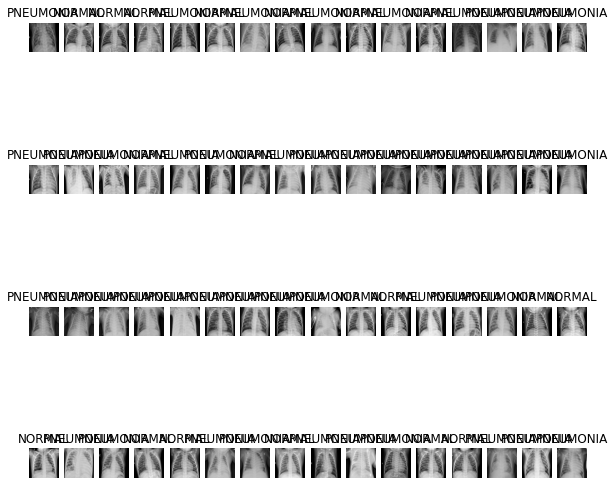

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

## dropout 제거

In [ ]:
def dense_block_B(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# Step 5. 데이터 imbalance 처리

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

In [ ]:
# 'EarlyStopping 으로 조기종료 실행
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
#BATCH_SIZE = 64, EPOCHS = 18

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/18
65/65 [==============================] - 78s 753ms/step - loss: 0.4247 - accuracy: 0.7599 - precision: 0.9518 - recall: 0.7139 - val_loss: 0.6324 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/18
65/65 [==============================] - 48s 753ms/step - loss: 0.2125 - accuracy: 0.9120 - precision: 0.9799 - recall: 0.8999 - val_loss: 0.6763 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 3/18
65/65 [==============================] - 50s 776ms/step - loss: 0.1619 - accuracy: 0.9406 - precision: 0.9830 - recall: 0.9363 - val_loss: 0.8679 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/18
65/65 [==============================] - 52s 800ms/step - loss: 0.1528 - accuracy: 0.9471 - precision: 0.9823 - recall: 0.9461 - val_loss: 0.9014 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/18
65/65 [==============================] - 46s 719ms/step - loss: 0.1156 - accuracy: 0.9582

In [21]:
#BATCH_SIZE = 16, EPOCHS = 23

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/23
261/261 [==============================] - 62s 189ms/step - loss: 0.3989 - accuracy: 0.8151 - precision: 0.9489 - recall: 0.7943 - val_loss: 0.6905 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/23
261/261 [==============================] - 49s 187ms/step - loss: 0.2312 - accuracy: 0.9112 - precision: 0.9730 - recall: 0.9057 - val_loss: 1.3126 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/23
261/261 [==============================] - 49s 188ms/step - loss: 0.1979 - accuracy: 0.9270 - precision: 0.9742 - recall: 0.9262 - val_loss: 1.1019 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/23
261/261 [==============================] - 50s 190ms/step - loss: 0.1812 - accuracy: 0.9315 - precision: 0.9770 - recall: 0.9298 - val_loss: 0.0776 - val_accuracy: 0.9750 - val_precision: 0.9907 - val_recall: 0.9752
Epoch 5/23
261/261 [==============================] - 51s 196ms/step - loss: 0.1697 - accura

In [24]:
#BATCH_SIZE = 16, EPOCHS = 25
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 79s 190ms/step - loss: 0.4236 - accuracy: 0.7912 - precision: 0.9490 - recall: 0.7602 - val_loss: 0.6194 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2336 - accuracy: 0.9164 - precision: 0.9732 - recall: 0.9127 - val_loss: 1.0897 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 188ms/step - loss: 0.2250 - accuracy: 0.9159 - precision: 0.9706 - recall: 0.9148 - val_loss: 1.2397 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 50s 193ms/step - loss: 0.1955 - accuracy: 0.9286 - precision: 0.9747 - recall: 0.9283 - val_loss: 0.0795 - val_accuracy: 0.9673 - val_precision: 0.9692 - val_recall: 0.9869
Epoch 5/25
261/261 [==============================] - 51s 195ms/step - loss: 0.1773 - accura

# Step 7. 결과 확인

### 0️⃣번 째 시도
- 변경 BATCH_SIZE = 64, EPOCHS = 18
- 결과   
    Loss: 1.0750070810317993,   
    Accuracy: 0.7628205418586731,   
    Precision: 0.7274436354637146,   
    Recall: 0.9923076629638672   

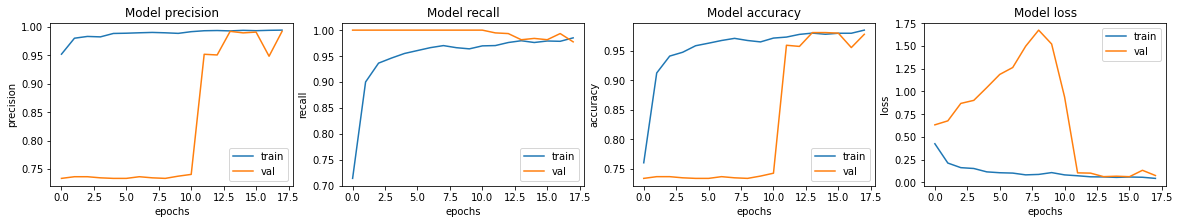

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

10/10 [==============================] - 4s 422ms/step - loss: 1.0750 - accuracy: 0.7628 - precision: 0.7274 - recall: 0.9923
Loss: 1.0750070810317993,
Accuracy: 0.7628205418586731,
Precision: 0.7274436354637146,
Recall: 0.9923076629638672


### 1️⃣번 째 시도
- 변경 BATCH_SIZE = 16, EPOCHS = 23
- 결과   
    Loss: 1.3846198320388794,   
    Accuracy: 0.7516025900840759,   
    Precision: 0.7155963182449341,   
    Recall: 1.0   

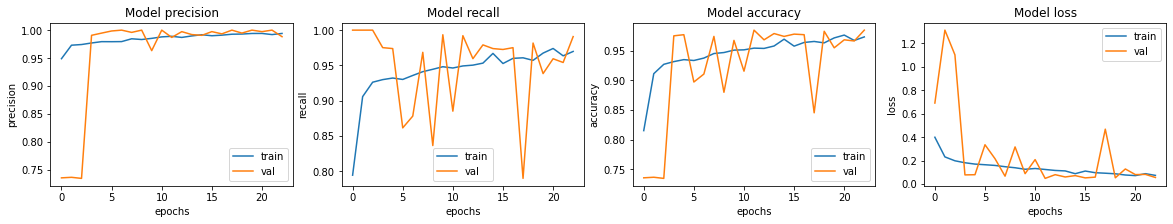

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.3846 - accuracy: 0.7516 - precision: 0.7156 - recall: 1.0000
Loss: 1.3846198320388794,
Accuracy: 0.7516025900840759,
Precision: 0.7155963182449341,
Recall: 1.0


### 2️⃣번 째 시도
- 변경 BATCH_SIZE = 16, EPOCHS = 25
- 결과   
    Loss: 0.3523915708065033,   
    Accuracy: 0.8862179517745972,   
    Precision: 0.903797447681427,   
    Recall: 0.9153845906257629   

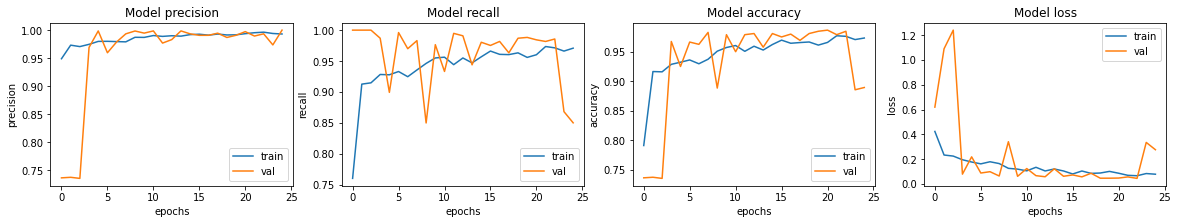

In [25]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [27]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.3524 - accuracy: 0.8862 - precision: 0.9038 - recall: 0.9154
Loss: 0.3523915708065033,
Accuracy: 0.8862179517745972,
Precision: 0.903797447681427,
Recall: 0.9153845906257629


# 🤔회고🤔

### <이번 프로젝트에서 어려웠던 점>
1. augmentation 오류   
- 데이터 증강 후 모델 학습을 시키고 싶어 여러차례 진행하였으나 시각화되는 과정에서 계속되는 오류로 진행하지 못하였다.
- TypeError: Invalid shape (16, 180, 180, 3) for image data

### <프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점>
1. Augmentation   
- 데이터 증강은 데이터가 부족할 때 유용하게 사용할 수 있다.
- 이미지 데이터 증강 방식은 많지만 텍스트 데이터 증강은 아직도 많지가 않다.
- 이미지 데이터 증강에는 다양한 방식이 있다.
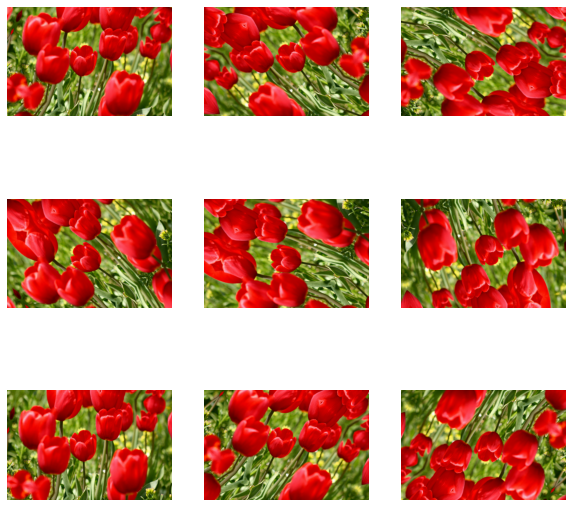
- 이미지 데이터 증강
 import Augmentor
 
    - 증강 시킬 이미지 폴더 경로   
    img = Augmentor.Pipeline("/content/drive/test")   

    - 좌우 반전   
    img.flip_left_right(probability=1.0)   

    - 상하 반전   
    img.flip_top_bottom(probability=1.0)   

    - 모퉁이 왜곡   
    img.skew_corner(probability=1.0)   

    - 회전&크롭   
    img.rotate_without_crop(probability=1, max_left_rotation=0.8, max_right_rotation=0.8, expand=False, fillcolor=None)   

    - 왜곡   
    img.random_distortion(probability=1, grid_width=10, grid_height=10, magnitude=30)   

    - 확대   
    img.zoom_random(probability=1, percentage_area=0.8)   

    - 크롭   
    img.crop_random(probability=1, percentage_area=0.8, randomise_percentage_area=False)   

    - 랜덤 지우기   
    img.random_erasing(probability=1.0, rectangle_area=0.3)/   

    - 증강 이미지 수   
    img.sample(1)   
    

2. 미니배치   
- 데이터가 엄청나게 많은 경우 전체데이터를 보고 최적화를 할 때 엄청난 시간이 할애할 수 있음
- 정확도는 좀 떨어지지만 Batch Size를 줄여서 시간을 단축시키는 것


### <루브릭 평가 지표를 맞추기 위해 시도한 것들>
1. BATCH_SIZE와 EPOCHS를 조절하면서 지표를 맞추기 위해 시도함   
    보통 BATCH_SIZE 사이즈는 크면 클수록 정확도가 올라가는 특징이 있다.
2. 지난번 LMS 하면서 배웠던 조기 종료를 적용시켜 주었다.
    따라서 epoch를 계속해서 조정하지 않아도 최적의 결과가 나올 수 있게 하였다.
3. 이미지 데이터 증강을 통해 학습을 좀 더 안정화시키고자 하였다.
4. dropout을 제거하고 학습을 통해 정확도를 높이고자 하였다.

### <만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정>
Accuracy 88%로 매우 잘 달성하였다!

### <자기 다짐>
 한 달 반 정도 지났는데 신기하게도 전체적으로 감이 잡힌다.   
 CV와 NL 둘 다 흥미롭지만 어떤 분야를 좀 더 깊게 공부할지에 대해 고민을 해봐야 할 것 같다.   

# Reference
1. 데이터 증강 : https://overface.tistory.com/557
2. 이미지 데이터 증강 기법 : https://hoya012.github.io/blog/Image-Data-Augmentation-Overview/
3. 이미지 데이터 증강 코드 : https://velog.io/@baes616/Augmentation-%EC%9D%B4%EC%9A%A9%ED%95%9C-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%A6%9D%EA%B0%95-%EC%9E%91%EC%97%85google-colab